# Image Segmentation

## Libraries and Utilities

In [2]:
import os
from pathlib import Path

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm, trange
from cv2.typing import MatLike
from numpy.typing import NDArray
from scipy.spatial import distance as scipy_distance
import scipy.spatial as scipy_spatial

notebook_dir = Path(os.getcwd())
output_dir = notebook_dir / 'output'

image = cv.imread('2-image.jpg')

In [3]:
def showImageCV(
    img: MatLike, title: str | None = None, fname: str | None = None
):
    # Convert BGR image (OpenCV default) to RGB for visualization
    if len(img.shape) == 3:  # if the image has channels
        img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    else:
        img_rgb = img

    # Adjust figure size to match image aspect ratio
    dpi = 80
    height, width = img.shape[:2]
    figsize = width / dpi, height / dpi

    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1], frameon=False)

    # Display grayscale image if it's a single channel
    if len(img.shape) == 2 or img.shape[2] == 1:
        ax.imshow(img_rgb, cmap='gray', vmin=0, vmax=255)
    else:
        ax.imshow(img_rgb)

    ax.axis('off')

    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', pad_inches=0)

    plt.show()

## A. Image Segmentation using K-means Clustering

In [4]:
def kmeans_clustering(
    img: MatLike,
    k: int,
    means: NDArray[np.int8],
    threshold: float = 0.1,
    n_iterations: int = 100,
):
    height, width, channels = img.shape
    img = img.reshape((-1, channels))
    prev_means = np.copy(means)

    # Iterate until convergence or max iterations
    for i in np.arange(n_iterations):
        # Compute pairwise distances and assign clusters
        distances = scipy_distance.cdist(img, means, 'euclidean')
        cluster_assignments = np.argmin(distances, axis=1)

        # Update means
        for j in range(k):
            if np.sum(cluster_assignments == j) == 0:
                # If there are no pixels in the cluster, reinitialize centroid
                means[j] = np.random.randint(0, 256, size=channels)
                continue
            means[j] = np.mean(img[cluster_assignments == j], axis=0)

        # Check convergence
        delta = np.linalg.norm(means - prev_means)
        if delta < threshold:
            break

        # Update previous means
        prev_means = np.copy(means)

    # Assign pixels to their cluster means
    img_clustered = np.zeros(img.shape)
    for i in range(k):
        img_clustered[cluster_assignments == i] = means[i]

    # Reshape image and return
    return img_clustered.reshape((height, width, channels)).astype(np.uint8)


def initialize_means(
    img: MatLike,
    k: int,
    n_initial_guesses: int = 50,
) -> NDArray[np.int8]:
    _, _, channels = img.shape
    img = img.reshape((-1, channels))

    # Randomly initialize n_initial_guesses means
    initial_means = np.random.randint(
        0, 256, size=(n_initial_guesses, channels)
    )

    # Compute pairwise distances between each pixel and guesses
    distances = scipy_distance.cdist(img, initial_means, 'euclidean')

    # Find the n_initial_guesses means with the k smallest average distances
    avg_distances = np.mean(distances, axis=0)
    return initial_means[np.argsort(avg_distances)[:k]]


def kmeans(
    img: MatLike,
    k: int,
    threshold: float = 0.1,
    n_iterations: int = 100,
):
    means = initialize_means(img, k, n_initial_guesses=50)
    return kmeans_clustering(img, k, means, threshold, n_iterations)


def initialize_means_pp(img: MatLike, k: int):
    _, _, channels = img.shape
    img = img.reshape((-1, channels))

    means = np.zeros((k, 3))
    means[0] = np.random.randint(0, 256, size=3)

    for i in range(1, k):
        distances = scipy_distance.cdist(img, means[:i], 'euclidean')
        min_distances = np.min(distances, axis=1)

        # Compute the probability of each pixel being chosen as a mean
        probs = min_distances / np.sum(min_distances)

        # Choose a pixel as a mean based on the probability distribution
        means[i] = img[np.random.choice(len(img), p=probs)]

    return means


def kmeans_pp(
    img: MatLike,
    k: int,
    threshold: float = 0.1,
    n_iterations: int = 100,
):
    means = initialize_means_pp(img, k)
    return kmeans_clustering(img, k, means, threshold, n_iterations)

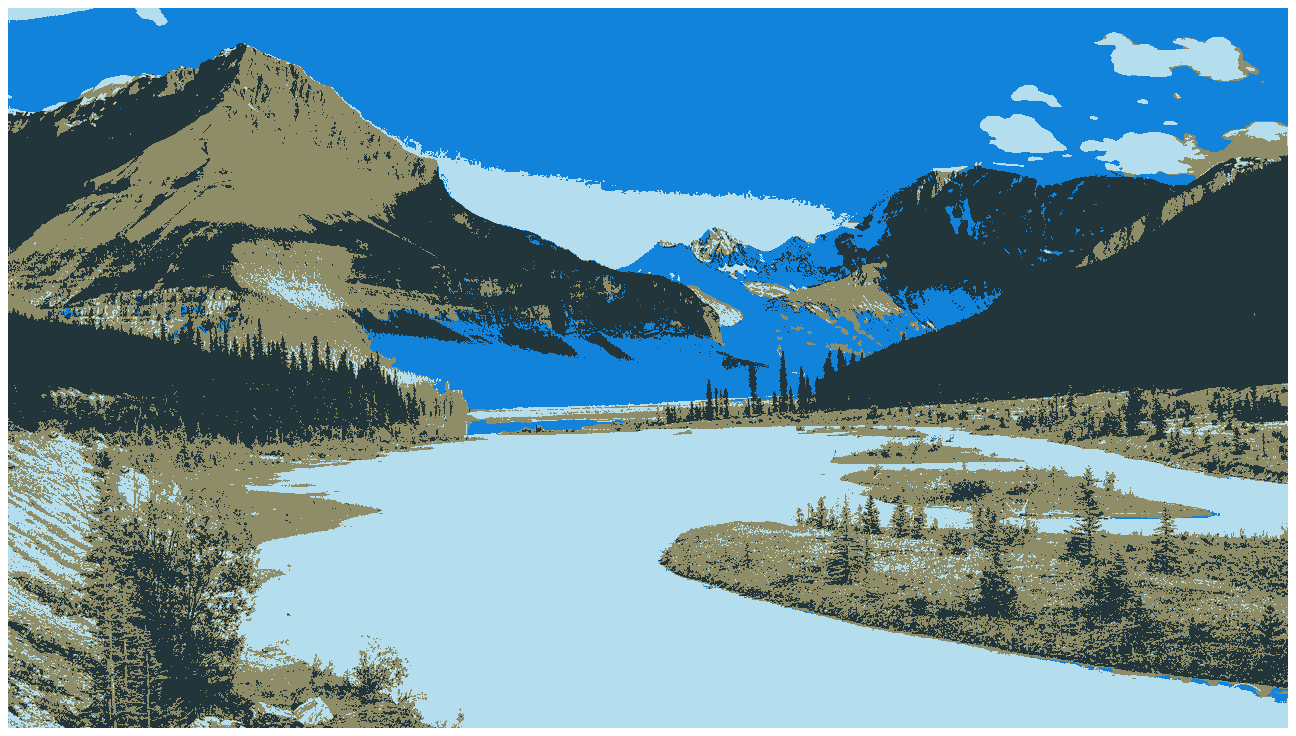

In [5]:
# perform k-means clustering
img_clustered = kmeans(image, 4)
showImageCV(img_clustered)

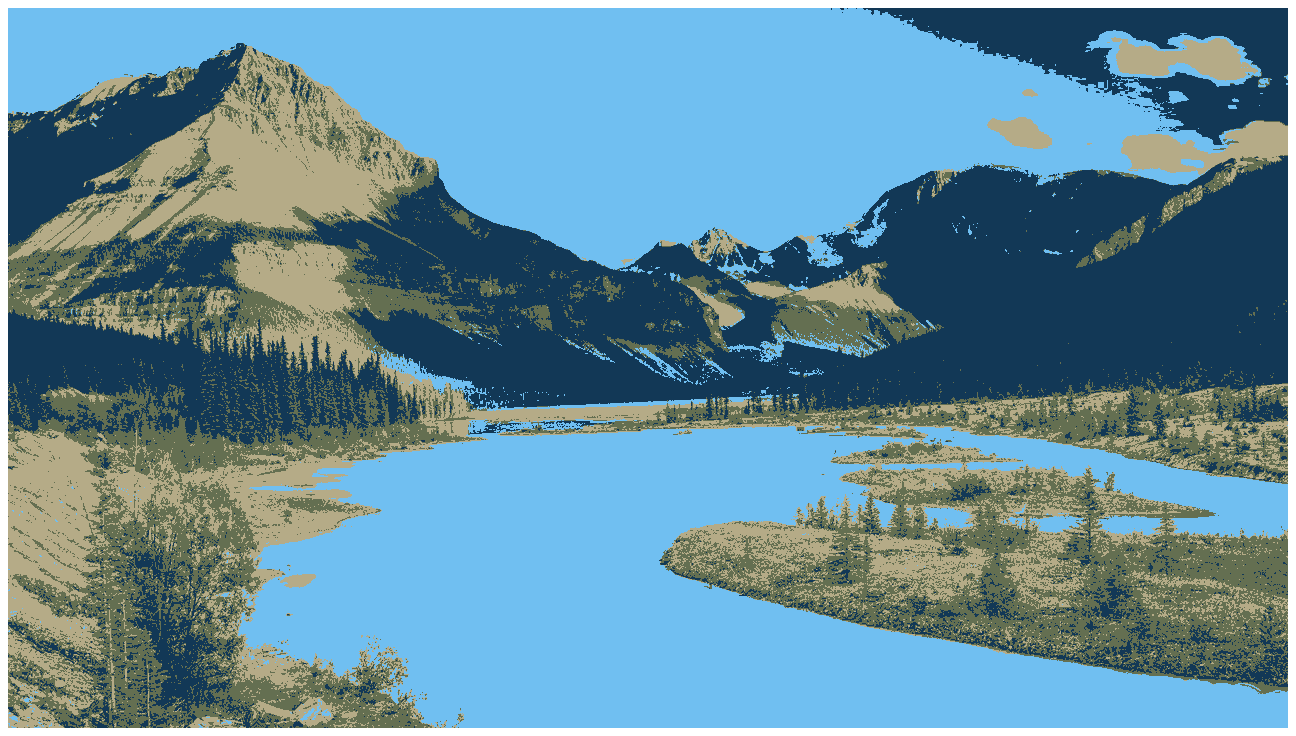

In [6]:
# perform k-means++ clustering
img_clustered_pp = kmeans_pp(image, 4)
showImageCV(img_clustered_pp)

## B. Image Segmentation using Mean Shift Clustering

In [7]:
def meanshift(
    img: MatLike,
    band_width: int = 5,
    threshold: float = 0.1,
    n_iterations: int = 100,
):
    height, width, channels = img.shape

    # flatten img and append x and y coordinates to each pixel
    img_flat = img.reshape((-1, channels))
    img_tree = scipy_spatial.KDTree(img_flat)

    means = np.copy(img_flat)
    means_stable = np.zeros(means.shape[0], dtype=bool)
    threshold_squared = threshold**2

    # Iterate over the number of iterations
    for iteration in np.arange(n_iterations):
        unstable_indices = np.where(~means_stable)[0]
        means_tree = scipy_spatial.KDTree(means[unstable_indices])

        neigbors_list = means_tree.query_ball_tree(
            img_tree, band_width, p=2, eps=0
        )

        updated_means = np.zeros((unstable_indices.shape[0], channels))
        for i, neighbors in enumerate(neigbors_list):
            if len(neighbors) == 0:
                continue
            updated_means[i] = np.mean(means[neighbors], axis=0)
            print(updated_means[i])

        # Check convergence
        delta_squared = np.sum(
            (updated_means - means[unstable_indices]) ** 2, axis=1
        )
        means_stable[unstable_indices] = delta_squared < threshold_squared

        # update means
        means[unstable_indices] = updated_means

        print(
            f'#{iteration + 1}: {np.sum(means_stable) / len(means):.2%} stable'
        )

        # Check convergence
        if np.all(means_stable):
            break

    return means.reshape((height, width, channels)).astype(np.uint8)

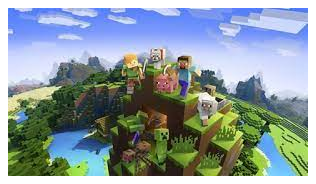

In [8]:
image2 = cv.imread('2-masterpiece.jpg')
showImageCV(image2)

#1: 37.04% stable
#2: 53.24% stable
#3: 58.64% stable
#4: 61.68% stable
#5: 64.37% stable
#6: 66.27% stable
#7: 68.23% stable
#8: 70.04% stable
#9: 71.81% stable
#10: 72.90% stable
#11: 74.23% stable
#12: 75.70% stable
#13: 78.30% stable
#14: 80.39% stable
#15: 83.16% stable
#16: 90.26% stable
#17: 92.51% stable
#18: 93.44% stable
#19: 94.17% stable
#20: 94.75% stable
#21: 95.16% stable
#22: 95.43% stable
#23: 95.77% stable
#24: 96.06% stable
#25: 96.46% stable
#26: 96.77% stable
#27: 97.62% stable
#28: 97.69% stable
#29: 97.73% stable
#30: 97.77% stable
#31: 97.79% stable
#32: 97.80% stable
#33: 97.80% stable
#34: 97.80% stable
#35: 97.80% stable
#36: 97.80% stable
#37: 97.80% stable
#38: 97.80% stable
#39: 97.80% stable
#40: 97.80% stable
#41: 97.80% stable
#42: 97.80% stable
#43: 97.80% stable
#44: 97.80% stable
#45: 97.80% stable
#46: 97.80% stable
#47: 97.80% stable
#48: 97.80% stable
#49: 97.80% stable
#50: 97.80% stable
#51: 97.80% stable
#52: 97.80% stable
#53: 97.80% stable
#5

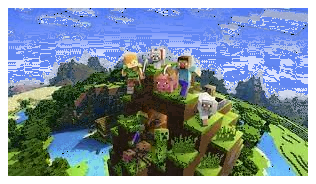

In [10]:
# perform mean-shift clustering
img_meanshift = meanshift(image2, band_width=4, threshold=0.8)
showImageCV(img_meanshift)